In [12]:
import librosa
import numpy as np

In [13]:
audio, sr = librosa.load("test.opus", sr=16000)  # 1D array of amplitudes
print(f"Audio Shape: {audio.shape}, Sample Rate: {sr}")

Audio Shape: (46685,), Sample Rate: 16000


In [14]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

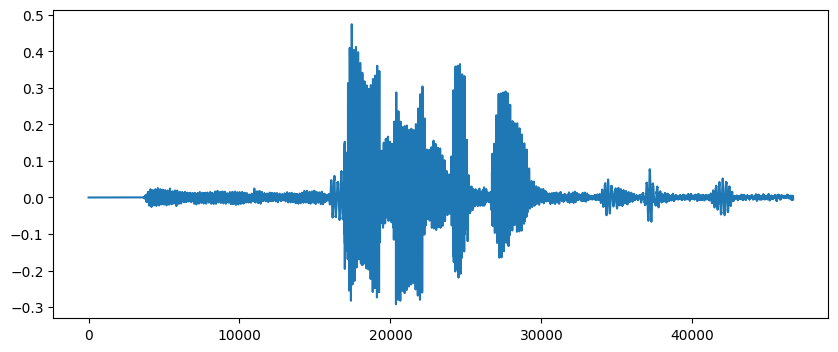

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(audio)

In [16]:
import os
import librosa
import librosa.display
from tqdm import tqdm

# Lists to store data
audios = []
labels = []
audio_spectrograms = []

# Fixed parameters
fixed_length = 16000  # 1 sec at 16kHz (adjust as needed)
n_fft = 1024  # FFT window size
hop_length = 512  # Hop length for STFT
n_mels = 128  # Mel frequency bins (optional)

# Data loading loop
data_path = 'test'  # Path to dataset

for dir_name in os.listdir(data_path):
    dir_path = os.path.join(data_path, dir_name)
    
    if not os.path.isdir(dir_path):
        continue  # Skip non-directory files
    
    for file in tqdm(os.listdir(dir_path), desc=f'Loading {dir_name}'):
        file_path = os.path.join(dir_path, file)
        
        try:
            # Load audio with fixed sample rate
            audio, sr = librosa.load(file_path, sr=16000)
            
            # Pad or truncate to fixed length
            audio = librosa.util.fix_length(audio, size=fixed_length)
            
            # Compute STFT and convert to dB spectrogram
            spectrogram = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
            spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
            
            # Normalize spectrogram (optional)
            spectrogram_db = (spectrogram_db - spectrogram_db.min()) / (spectrogram_db.max() - spectrogram_db.min())

            # Store data
            audios.append(audio)
            audio_spectrograms.append(spectrogram_db)
            labels.append(dir_name)

        except Exception as e:
            print(f"Error processing {file}: {e}")

# Convert to NumPy arrays
audios = np.array(audios)
audio_spectrograms = np.array(audio_spectrograms, dtype=np.float32)

print(f"Loaded {len(audios)} audio files with shape {audios.shape}")
print(f"Spectrogram shape: {audio_spectrograms.shape}")


Loading on: 100%|██████████| 1656/1656 [00:02<00:00, 826.78it/s]


Loaded 3177 audio files with shape (3177, 16000)
Spectrogram shape: (3177, 513, 32)


In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [18]:
print(audios.shape)
print(labels.shape)
print(audio_spectrograms.shape)

(3177, 16000)
(3177,)
(3177, 513, 32)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(audio_spectrograms, labels, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2541, 513, 32)
(636, 513, 32)
(2541,)
(636,)


In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [21]:
model=Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(513, 32, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history=model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/40
80/80 [==============================] - 2s 14ms/step - loss: 0.6154 - accuracy: 0.6651 - val_loss: 0.5136 - val_accuracy: 0.7563
Epoch 2/40
80/80 [==============================] - 1s 13ms/step - loss: 0.4373 - accuracy: 0.8209 - val_loss: 0.4182 - val_accuracy: 0.8223
Epoch 3/40
80/80 [==============================] - 1s 13ms/step - loss: 0.3326 - accuracy: 0.8709 - val_loss: 0.3680 - val_accuracy: 0.8491
Epoch 4/40
80/80 [==============================] - 1s 13ms/step - loss: 0.2899 - accuracy: 0.8843 - val_loss: 0.4521 - val_accuracy: 0.7956
Epoch 5/40
80/80 [==============================] - 1s 13ms/step - loss: 0.2118 - accuracy: 0.9339 - val_loss: 0.3431 - val_accuracy: 0.8569
Epoch 6/40
80/80 [==============================] - 1s 13ms/step - loss: 0.1544 - accuracy: 0.9559 - val_loss: 0.4911 - val_accuracy: 0.7846
Epoch 7/40
80/80 [==============================] - 1s 13ms/step - loss: 0.1235 - accuracy: 0.9662 - val_loss: 0.3448 - val_accuracy: 0.8538
Epoch 8/40
80

In [23]:
y_pred=model.predict(X_test)
y_pred=np.where(y_pred>0.5, 1, 0)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

20/20 [==============================] - 0s 3ms/step
[[272  50]
 [ 39 275]]


In [24]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       322
           1       0.85      0.88      0.86       314

    accuracy                           0.86       636
   macro avg       0.86      0.86      0.86       636
weighted avg       0.86      0.86      0.86       636

0.8602583376191796


In [25]:
def get_prediction(audio_path:str):
    audio, sr = librosa.load(audio_path, sr=16000)  # 1D array of amplitudes
    audio = librosa.util.fix_length(audio, size=fixed_length)
    spectrogram = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
    spectrogram_db = (spectrogram_db - spectrogram_db.min()) / (spectrogram_db.max() - spectrogram_db.min())
    spectrogram_db = np.expand_dims(spectrogram_db, axis=-1)
    spectrogram_db = np.expand_dims(spectrogram_db, axis=0)
    prediction = model.predict(spectrogram_db)
    return prediction

In [26]:
import sys
sys.getsizeof(model)

48

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
def representative_data_gen():
    for _ in range(100):
        sample_input = np.random.rand(1, 513, 32, 1).astype(np.float32)  # Adjust shape as per input
        yield [sample_input]

# Convert the model to TensorFlow Lite format with full integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable optimization
converter.representative_dataset = representative_data_gen  # Use dataset for quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Force full integer quantization
converter.inference_input_type = tf.int8  # Input type: int8
converter.inference_output_type = tf.int8  # Output type: int8

# Convert and save the optimized model
tflite_model = converter.convert()
with open("cnn_model_compressed.tflite", "wb") as f:
    f.write(tflite_model)

print("✔ Model successfully converted to highly compressed TensorFlow Lite format!")

INFO:tensorflow:Assets written to: C:\Users\anasm\AppData\Local\Temp\tmp74oc3y9u\assets


INFO:tensorflow:Assets written to: C:\Users\anasm\AppData\Local\Temp\tmp74oc3y9u\assets


✔ Model successfully converted to highly compressed TensorFlow Lite format!


In [29]:
def convert_to_header(tflite_model_path, header_file_path):
    with open(tflite_model_path, 'rb') as f:
        byte_array = f.read()
    with open(header_file_path, 'w') as header_file:
        header_file.write('#include <stdint.h>\n')
        header_file.write('const uint8_t g_model[] = {')
        header_file.write(','.join(f'0x{b:02x}' for b in byte_array))
        header_file.write('};\n')

convert_to_header('cnn_model_compressed.tflite', 'cnn_model_compressed.h')

In [30]:
from collections import Counter

Counter(y_test)

Counter({0: 322, 1: 314})